# Enem - How socioeconomic factors are tied to the final score 

In this project, I will use the publicly available data provided by the Brazilian government on the Exame Nacional do Ensino Médio (ENEM), the main entrance exam for most public universities in Brazil. Since the test is taken by millions of graduating high school students every year, analyzing this exam is very illuminating when trying to understand Brazilian education - specially the inequalities and injustices that are present in our system.

The data I will analyze regards the 2014 ENEM and was obtained in https://dados.gov.br/. 

My main goals here are: 
1) To clean the data set and to make it usable for my analysis purposes.

2) To analyze how different socioeconomic factors influence the ENEM scores. 

3) To train machine learning models to predict the scores based on socioeconomic factors. It is not my intention here to predict any particular score - the score itself depends on many features that are symply not available to us, and on the candidate itself. Nonetheless, the features should be somehow correlated with the scores - making it possible to construct a machine learning model that predicts, with some accuracy, the scores of candidates, as long as we have a large number of observations.

In [49]:
import numpy as np #NumPy
import pandas as pd #pandas
import seaborn as sns #seaborn
from matplotlib import pyplot as plt #matplotlib
import random #random
%matplotlib inline

sns.set_style('darkgrid')

The data set is very large. There were about 9,500,000 candidates who took the 2014 test. Since it would be computationally very costly to work with this imense data set, I will randomly select a sample of 1,000,000 candidates and work with them as if they were a representative size of the candidate pool.

In [50]:
n = 9500000
s = 1000000
skip = sorted(random.sample(range(1, n+1),n-s)) #randomly choose only 1,000,000 observations from the data
enem_df = pd.read_csv('MICRODADOS_ENEM_2014.csv', header = 0, nrows = 1000000, sep=',', encoding='latin-1', skiprows = skip) #read the csv file

In [51]:
enem_df.head()

,NU_INSCRICAO,NU_ANO,COD_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,COD_UF_RESIDENCIA,UF_RESIDENCIA,IN_ESTUDA_CLASSE_HOSPITALAR,COD_ESCOLA,COD_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,...,Q067,Q068,Q069,Q070,Q071,Q072,Q073,Q074,Q075,Q076
0,140000000030,2014,2304400,FORTALEZA,23,CE,0,NaN,NaN,NaN,...,A,B,B,A,A,A,B,B,B,B
1,140000000032,2014,5300108,BRASILIA,53,DF,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,140000000037,2014,2603454,CAMARAGIBE,26,PE,0,26165112.0,2603454.0,CAMARAGIBE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,140000000053,2014,5002704,CAMPO GRANDE,50,MS,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,140000000057,2014,5300108,BRASILIA,53,DF,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There is a dictionary file, under the name 'Dicionário_Microdados_Enem_2014_xlsx' (in Portuguese) in our folder. Many columns are self explanatory. The columns that have names such as 'Q001', 'Q002' etc. are answers to a socioeconomic questionaire. For example, one of the most important questions for our analysis is Q03, "What is your family's total income?". The other questions can be view in the dictionary file. 

I will create in the cell below a list with the column names from the socioeconomic questionaire. My end goal is to analyze, based on the answers to the questionaire and some other features (below), the scores obtained by different candidates.

In [52]:
cols = []
for i in range(1,54):
    cols.append('Q0' + str(i).zfill(2)) #Here, I want to insert append to the cols list Q01, Q02, ..., Q053

In the next cells, add_cols is a list of interesting feature data. out_cols is a list of the output scores of the exam candidates for all five areas covered by the test. Finally, I am gonna merge all three lists together and select only the desired columns from our data frame. 

In [53]:
add_cols = ['UF_RESIDENCIA', 'IDADE', 'TP_SEXO', 'NACIONALIDADE', 'TP_ESCOLA', 'IN_TP_ENSINO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA'] #desired columns

In [54]:
out_cols = ['NOTA_CN', 'NOTA_CH', 'NOTA_LC', 'NOTA_MT', 'NU_NOTA_REDACAO'] #output columns - they represent the scores. 
#NOTA_CN - Natural Sciences grade
#NOTA_CH - Humanities grade
#NOTA_LC - Languages and communication grade
#NOTA_MT - Mathematics grade
#NU_NOTA_REDACAO - Essay grade

In [55]:
for col in add_cols:
    cols.append(col) 

for col in out_cols:
    cols.append(col)
    
enem_selected = enem_df[cols] #join all columns in the same list and choose the desired columns in enem_selected

Next, I will plot a heat map for the null values of enem_selected. My goal is to see how the null values are distributed throughout the data set.

<AxesSubplot:>

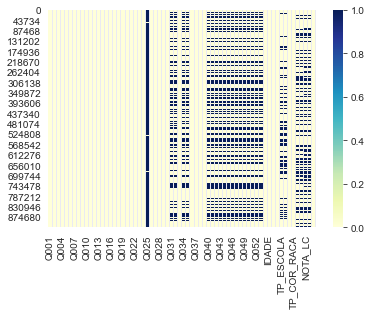

In [56]:
sns.heatmap(enem_selected.isnull(), cmap="YlGnBu")

Then, I will check which columns have any null values.

In [57]:
df_isnull_mean = np.mean(enem_selected.isnull()) 
df_isnull_mean[df_isnull_mean > 0]

Q025            0.990575
Q031            0.363910
Q032            0.363910
Q034            0.355417
Q035            0.355417
Q040            0.383136
Q041            0.383136
Q042            0.383136
Q043            0.383136
Q044            0.383136
Q045            0.383136
Q046            0.383136
Q047            0.383136
Q048            0.383136
Q049            0.383136
Q050            0.383136
Q051            0.383136
Q052            0.383136
Q053            0.383136
IDADE           0.000030
TP_ESCOLA       0.227768
IN_TP_ENSINO    0.227768
NOTA_CN         0.293392
NOTA_CH         0.293392
NOTA_LC         0.314419
NOTA_MT         0.314419
dtype: float64

Since the features I am interested in analyzing are the scores of the candidates, I will drop observations for which any score is Null for now. I am generally going to drop all other features for which the proportion of Nulls is greater than 0.35 (excluding the scores themselves). I chose to do so because, upon checking what the features tell us about the candidates, I decided that those features where not of particular interest. 

The school type ('TP_ESCOLA') and the type of institution ('IN_TP_ENSINO') are still interesting and are essential to the analises I wish to make. I will deal with them later.

In [58]:
col_missing = df_isnull_mean[df_isnull_mean > 0.35].index #obtain the columns that have more than 35% of null values
enem_selected = enem_selected.drop(col_missing, axis = 1) #drop these columns

obs_missing = enem_selected[(enem_selected['NOTA_CN'].isnull()) | (enem_selected['NOTA_CH'].isnull()) | (enem_selected['NOTA_LC'].isnull()) | (enem_selected['NOTA_MT'].isnull()) | (enem_selected['NU_NOTA_REDACAO'].isnull())].index
enem_selected = enem_selected.drop(obs_missing, axis = 0) #obtain observations for which any score is null and drop them

med_age = enem_selected['IDADE'].median()
enem_selected['IDADE'] = enem_selected['IDADE'].fillna(med_age) #fill the observations with null value for age with the median age

I will replace TP_ESCOLA (whether the school is private or public) and IN_TP_ESCOLA (regular, adult education or special school) by the mode value for each income category.

In [59]:
income_categories = enem_selected['Q003'].unique() #get the income categories from the answer to question Q003
enem_selected['TP_ESCOLA'] = enem_selected['TP_ESCOLA'].astype('category') #transform the TP_ESCOLA column (school type) in categorical variable

mode_per_category = {} #dict
for category in income_categories:
    m = enem_selected[enem_selected['Q003'] == category]['TP_ESCOLA'].describe().top #for each income category, obtain the most common school type
    mode_per_category[category] = m  #update dictionary
    
for row in enem_selected[enem_selected['TP_ESCOLA'].isnull()].index: 
    category = enem_selected.loc[row, 'Q003']
    enem_selected.loc[row, 'TP_ESCOLA'] = mode_per_category[category] #substitute null values with the mode for category

In [60]:
#Do the same as in the previous cell, but for the IN_TP_ENSINO

enem_selected['IN_TP_ENSINO'] = enem_selected['IN_TP_ENSINO'].astype('category')

mode_per_category = {}
for category in income_categories:
    m = enem_selected[enem_selected['Q003'] == category]['IN_TP_ENSINO'].describe().top
    mode_per_category[category] = m
    
for row in enem_selected[enem_selected['IN_TP_ENSINO'].isnull()].index:
    category = enem_selected.loc[row, 'Q003']
    enem_selected.loc[row, 'IN_TP_ENSINO'] = mode_per_category[category]

In [61]:
#enem_selected['NO_MUNICIPIO_RESIDENCIA'] = enem_selected['NO_MUNICIPIO_RESIDENCIA'].str.upper()

I will define a new column ('NOTA_MEDIA') with the mean score among the five areas for each candidate. 

In [62]:
enem_selected['NOTA_MEDIA'] = (enem_selected['NOTA_CN'] + enem_selected['NOTA_CH'] + enem_selected['NOTA_LC'] + enem_selected['NOTA_MT'] + enem_selected['NU_NOTA_REDACAO'])/5 #obtain the average score

# Exploratory data analysis

In the next two histograms, I am going to check the distribution of scores. In the first one, the distribution is shown regardless of school type. In the second one, however, the candidates were discrimated based on the type of school they attended. 1.0 represents public schools, while 2.0 represents private schools. 

<AxesSubplot:xlabel='NOTA_MEDIA', ylabel='Count'>

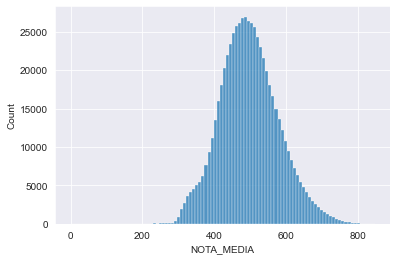

In [63]:
sns.histplot(data = enem_selected, x = 'NOTA_MEDIA', bins = 100) #plot the histogram for grades

<AxesSubplot:xlabel='NOTA_MEDIA', ylabel='Count'>

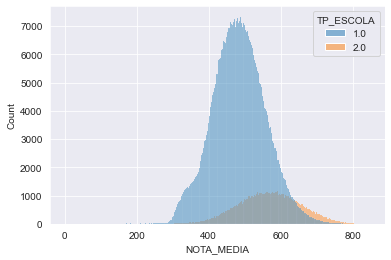

In [64]:
sns.histplot(data = enem_selected, x = 'NOTA_MEDIA', hue = 'TP_ESCOLA') #plot the histogram for the two different school types: public (1.0) or private (2.0)

Notice that the average score for private institutions is significantly higher than for public schools.

I wish to find out the average scores for different feature categories. I am going to start by calculating the average scores and standard deviation for each school type.

<AxesSubplot:xlabel='TP_ESCOLA', ylabel='NOTA_MEDIA'>

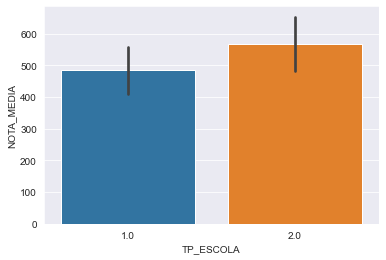

In [65]:
avg_per_type = enem_selected.groupby(['TP_ESCOLA'])[['NOTA_CN', 'NOTA_CH', 'NOTA_LC', 'NOTA_MT', 'NU_NOTA_REDACAO', 'NOTA_MEDIA']].mean()
std_per_type = enem_selected.groupby(['TP_ESCOLA'])[['NOTA_CN', 'NOTA_CH', 'NOTA_LC', 'NOTA_MT', 'NU_NOTA_REDACAO', 'NOTA_MEDIA']].std()
sns.barplot(x = 'TP_ESCOLA', y = 'NOTA_MEDIA', data = enem_selected, ci='sd') #bar plot of average scores for different types of school

We can see that private schools have an average score of over 550 points, while public schools have an average smaller than 500.

It is also interesting to ask ourselves if there is much variation among states.

<AxesSubplot:xlabel='UF_RESIDENCIA', ylabel='NOTA_MEDIA'>

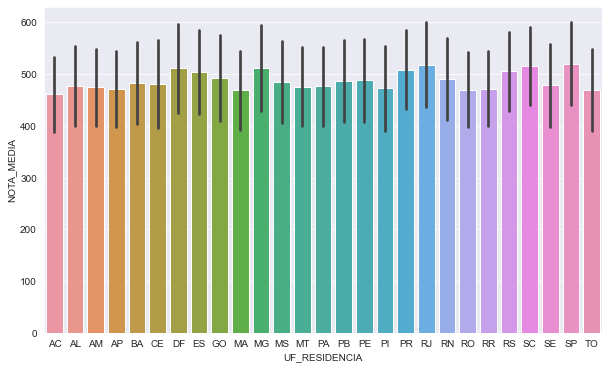

In [66]:
avg_per_type_state = enem_selected.groupby(['UF_RESIDENCIA'])[['NOTA_CN', 'NOTA_CH', 'NOTA_LC', 'NOTA_MT', 'NU_NOTA_REDACAO', 'NOTA_MEDIA']].mean()
std_per_type_state = enem_selected.groupby(['UF_RESIDENCIA'])[['NOTA_CN', 'NOTA_CH', 'NOTA_LC', 'NOTA_MT', 'NU_NOTA_REDACAO', 'NOTA_MEDIA']].std()

plt.figure(figsize=(10,6)) 
enem_selected = enem_selected.sort_values(['UF_RESIDENCIA'])
sns.barplot(x = 'UF_RESIDENCIA', y = 'NOTA_MEDIA', data = enem_selected, ci='sd') #bar plot for score distrubution for different States

Since there are 26 states plus the Federal District, it is better, for analysis purposes, to divide the states into the five regions in which Brazil is usually divided. Let's analyze it, then:

<AxesSubplot:xlabel='REGION', ylabel='NOTA_MEDIA'>

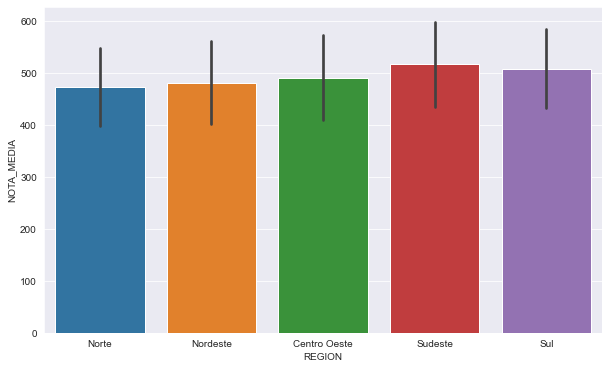

In [67]:
region_mapping = {'RS':'Sul', 'SC':'Sul', 'PR':'Sul', 'SP':'Sudeste', 'RJ':'Sudeste', 'MG':'Sudeste', 'ES':'Sudeste', 'BA':'Nordeste', 'SE':'Nordeste', 'AL':'Nordeste', 'PE':'Nordeste', 'PB':'Nordeste', 'RN':'Nordeste', 'CE':'Nordeste', 'MA':'Nordeste', 'PI':'Nordeste', 'MS':'Centro Oeste', 'MT': 'Centro Oeste', 'GO':'Centro Oeste', 'DF':'Centro Oeste', 'AM':'Norte', 'PA':'Norte', 'AC':'Norte', 'RO':'Norte', 'RR':'Norte', 'TO':'Norte', 'AP':'Norte'} #dictionary mapping each state to its region
enem_selected['REGION'] = enem_selected['UF_RESIDENCIA'].replace(region_mapping) #creates a column with the region of each candidate

plt.figure(figsize=(10,6))
sns.barplot(x = 'REGION', y = 'NOTA_MEDIA', data = enem_selected, ci='sd') #bar plot of the score distribution for each region

Note that the North is the region that has the smallest average grades, while the Southeast hast the largest. In fact, the only two regions whose average is above 500 points are the Southeast and the South. We can see a significant difference in grades among the regions. 

It is interesting to investigate how social differences affect the average grade. The next graph shows the differences in average score by ethnicity. Is important to emphasize that racial and socioeconomic factors are strongly correlated in Brazil, as they are in much of the world. People with different ethnic backgrounds may have, in average, different opportunities. That is why it is interesting to see how these differents may be reflected on the average grades by ethnicity.

The code works as follows: 

0 - Did not declare ethnicity;

1 - Branco;

2 - Preto;

3 - Pardo;

4 - Amarelo;

5 - Indígena. 

I did not translate the ethnicities into English, since they reflect a very specific Brazilian context and translating them would be very misleading. 

<AxesSubplot:xlabel='TP_COR_RACA', ylabel='NOTA_MEDIA'>

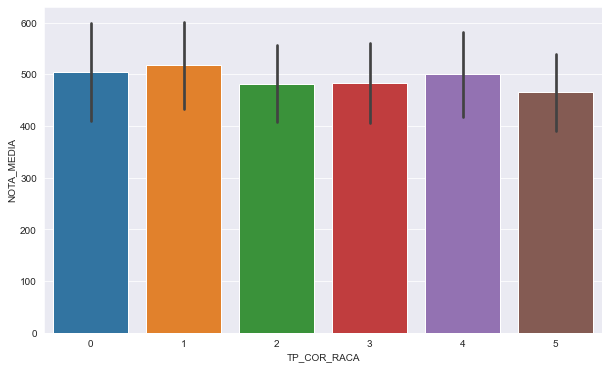

In [68]:
avg_per_race = enem_selected.groupby('TP_COR_RACA')[['NOTA_CN', 'NOTA_CH', 'NOTA_LC', 'NOTA_MT', 'NU_NOTA_REDACAO', 'NOTA_MEDIA']].mean()
std_per_race = enem_selected.groupby('TP_COR_RACA')[['NOTA_CN', 'NOTA_CH', 'NOTA_LC', 'NOTA_MT', 'NU_NOTA_REDACAO', 'NOTA_MEDIA']].std()

plt.figure(figsize=(10,6))
sns.barplot(x = 'TP_COR_RACA', y = 'NOTA_MEDIA', data = enem_selected, ci='sd')

It is specially interesting to analyze how the grades are distributed according to household income. 

<AxesSubplot:xlabel='Q003', ylabel='NOTA_MEDIA'>

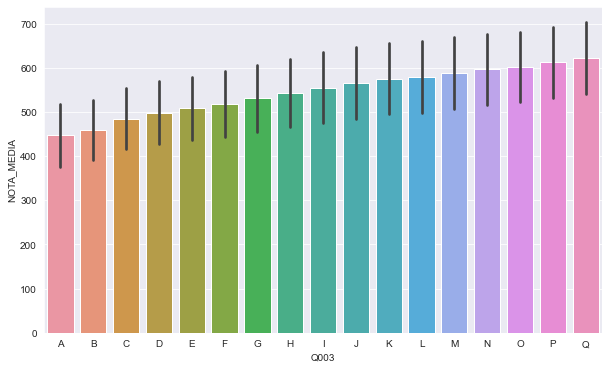

In [69]:
avg_per_income = enem_selected.groupby(['Q003'])[['NOTA_CN', 'NOTA_CH', 'NOTA_LC', 'NOTA_MT', 'NU_NOTA_REDACAO', 'NOTA_MEDIA']].mean()
std_per_income = enem_selected.groupby(['Q003'])[['NOTA_CN', 'NOTA_CH', 'NOTA_LC', 'NOTA_MT', 'NU_NOTA_REDACAO', 'NOTA_MEDIA']].std()

plt.figure(figsize=(10,6))
enem_selected = enem_selected.sort_values(['Q003'])
sns.barplot(x = 'Q003', y = 'NOTA_MEDIA', data = enem_selected, ci='sd')

It is fascinating to see that the average score increases a lot with the average household income. In fact, every income bracket has an average score greater  Specially, the increase is steeper for the lowest classes.

Since there are 17 different categories of income, I will change the categories a bit, just to make analysis a little easier. The categories will become as follows:

1 - No income to 1 minimum income;

2 - Between 1 and 5 times the minimum income;

3 - Between 5 and 10 times the minimum income;

4 - Between 10 and 15 times the minimum income;

5 - Between 15 and 20 times the minimum income;

6 - More than 20 times the minimum income; 

<AxesSubplot:xlabel='RENDA', ylabel='NOTA_MEDIA'>

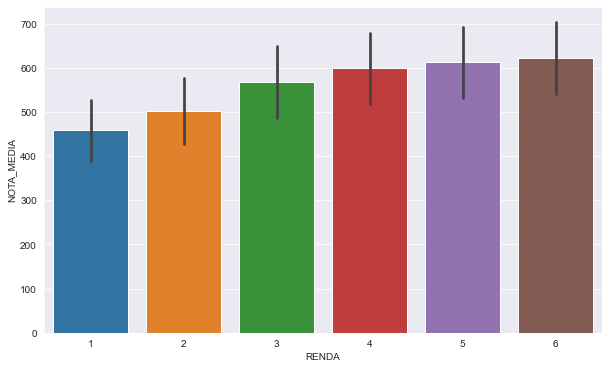

In [70]:
income_mapping = {'A':1, 'B':1, 'C':2, 'D':2, 'E':2, 'F':2, 'G':2, 'H':2, 'I':3, 'J':3, 'K':3, 'L':3, 'M':3, 'N':4, 'O':4, 'P':5, 'Q':6}
enem_selected['RENDA'] = enem_selected['Q003'].replace(income_mapping)
plt.figure(figsize=(10,6))
enem_selected = enem_selected.sort_values(['RENDA'])
sns.barplot(x = 'RENDA', y = 'NOTA_MEDIA', data = enem_selected, ci='sd')

Generally, higher income families in Brazil tend to send their children to private schools. For that reason, it is interesting to see whether the difference we saw between the average score for public and private schools can be explained, at least to a certain extent, by the income difference. 

In the next cell, I will plot the average score for different school types for students inside the same income bracket - resulting in 6 plots in total, one for each income bracket. 

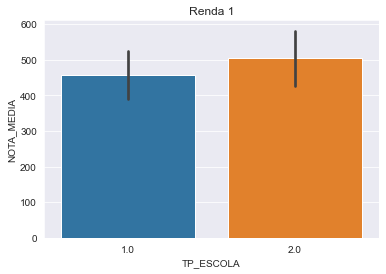

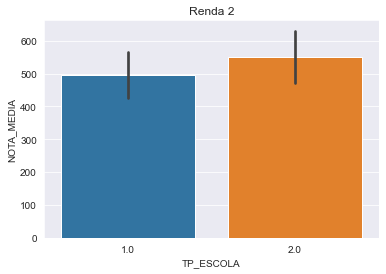

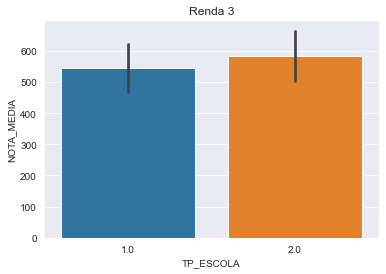

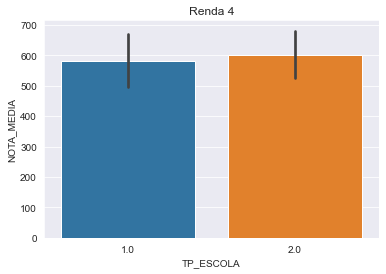

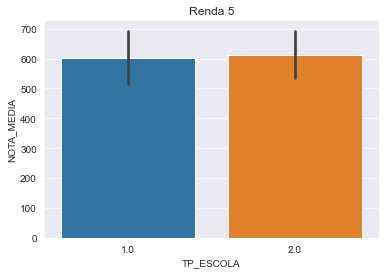

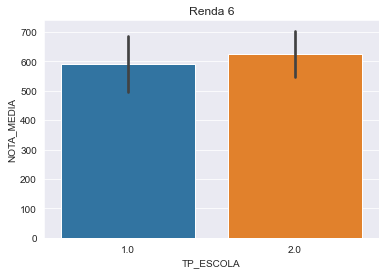

In [181]:
enem_incomes = {i:enem_selected[enem_selected['RENDA'] == i] for i in range(1,7)} #dictionary containing slices of data frame with different income brackets

for i in range(1, 7):
    sns.barplot(x = 'TP_ESCOLA', y = 'NOTA_MEDIA', data = enem_incomes[i], ci='sd') #bar plot of average scores for different types of school
    plt.title('Renda ' + str(i))
    plt.show()

For every income bracket, the average score for private schools is greater than for public schools. However, the difference is starker for lower income students. The score increases for both private and public schools with the candidate's income. This shows that, although the private and public school divide can be partly explained by the income difference, it is, by itself, an important predicting factor. 

What if we analyzed it the other way around? That is, for each school type, I want to plot the average grade as a function of the income bracket. My goal is to see if, for the same school type, the wealth difference is very significant.  

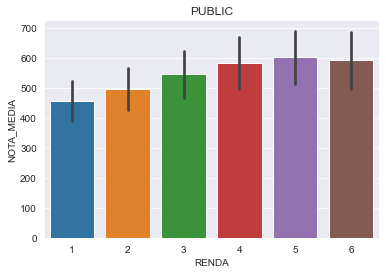

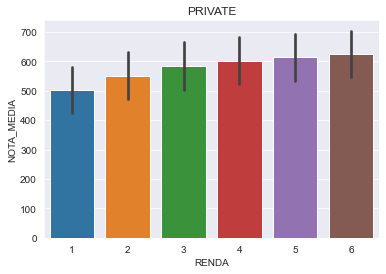

In [182]:
enem_school_type = {i:enem_selected[enem_selected['TP_ESCOLA'] == i] for i in range(1,3)}

for i in range(1, 3):
    enem_school_type[i] = enem_school_type[i].sort_values(['RENDA'])
    sns.barplot(x = 'RENDA', y = 'NOTA_MEDIA', data = enem_school_type[i], ci='sd') #bar plot of average scores for different types of school
    if i == 1: 
        plt.title('PUBLIC')
    else:
        plt.title('PRIVATE')
    plt.show()

With these plots, we can see clearly that, even for the same school type, the difference in wealth is a very important factor on the student's grades. 

With the exploratory data analysis performed above, we could see that there are many general trends in the ENEM scores based on socioeconomic factors. While it may not be very helpful to try to predict the ENEM outcome for one particular individual, it may be interesting to train machine learning models in order to predict the scores and detect general trends. That is what I am going to do in the remainder of this project.

First, I will transform every categorial column into categorical values (using dummy variables). For that, I will use the LabelEncoder function from sklearn.preprocessing.

In [72]:
from sklearn.preprocessing import LabelEncoder

In [73]:
enem_selected.columns

Index(['Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009',
       'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018',
       'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q026', 'Q027', 'Q028',
       'Q029', 'Q030', 'Q033', 'Q036', 'Q037', 'Q038', 'Q039', 'UF_RESIDENCIA',
       'IDADE', 'TP_SEXO', 'NACIONALIDADE', 'TP_ESCOLA', 'IN_TP_ENSINO',
       'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'NOTA_CN', 'NOTA_CH', 'NOTA_LC',
       'NOTA_MT', 'NU_NOTA_REDACAO', 'NOTA_MEDIA', 'REGION', 'RENDA'],
      dtype='object')

In [74]:
le = LabelEncoder()
encoded_enem_selected = enem_selected[['Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009',
       'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018',
       'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q026', 'Q027', 'Q028',
       'Q029', 'Q030', 'Q033', 'Q036', 'Q037', 'Q038', 'Q039', 'UF_RESIDENCIA', 'TP_SEXO',
       'NACIONALIDADE', 'TP_ESCOLA', 'IN_TP_ENSINO', 'TP_ESTADO_CIVIL',
       'TP_COR_RACA']].apply(le.fit_transform)

encoded_enem_selected[['IDADE', 'NOTA_CN', 'NOTA_CH', 'NOTA_LC', 'NOTA_MT',
       'NU_NOTA_REDACAO', 'NOTA_MEDIA']] = enem_selected[['IDADE', 'NOTA_CN', 'NOTA_CH', 'NOTA_LC', 'NOTA_MT',
       'NU_NOTA_REDACAO', 'NOTA_MEDIA']]

Firstly, I will use a tree model in order to predict the scores. This seems to be particularly interesting in this case, due to the presence of several categorical variables. I wil use a random forest model. 

# Tree model

In [75]:
from sklearn.model_selection import train_test_split #train-test split from sklearn

X = encoded_enem_selected[['Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009',
       'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018',
       'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q026', 'Q027', 'Q028',
       'Q029', 'Q030', 'Q033', 'Q036', 'Q037', 'Q038', 'Q039', 'UF_RESIDENCIA', 'IDADE', 'TP_SEXO',
       'NACIONALIDADE', 'TP_ESCOLA', 'IN_TP_ENSINO', 'TP_ESTADO_CIVIL',
       'TP_COR_RACA']] #define the features
y = encoded_enem_selected['NOTA_MEDIA'] #the desired output


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42) #since the dataset is pretty big, I will use only 5% of it as my test set. 

I will decide what is the ideal number of estimators for our random forest. For that, I will calculate the root mean squared error (RMSE) as a function of the number of estimators. For this part, I only used 50,000 observations in the train set, due to the large computational cost of testing different number of estimators.

In [87]:
m = 50000
rows = random.sample(list(X_train.index), m)
X_train_smaller = X_train.loc[rows]
y_train_smaller = y_train.loc[rows]

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

random_forest = [] #empty list. For each value of i (the number of estimators), I will append the RMSE to the list. 

for i in  range(1, 60):
    rfr = RandomForestRegressor(n_estimators = i) #create the random forest model with i estimators  
    rfr.fit(X_train_smaller, y_train_smaller) #fit to our train set
    rfr_pred = rfr.predict(X_test) #predict based on our test features
    random_forest.append([i, np.sqrt(metrics.mean_squared_error(y_test, rfr_pred))]) #append the RMSE. 

<AxesSubplot:xlabel='i', ylabel='Root mean squared error'>

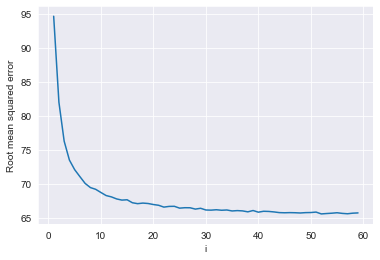

In [88]:
random_forest_pd = pd.DataFrame(random_forest, columns = ['i', 'Root mean squared error']) #convert the list into a pandas DataFrame
sns.lineplot(x = 'i', y = 'Root mean squared error', data = random_forest_pd) #plot the RMSE as a function of i

I will chose i = 40 for the number of estimators, since the MSE does not seem to decrease much after that.

In [89]:
rfr = RandomForestRegressor(n_estimators = 40) #create the model
rfr.fit(X_train, y_train) #train
rfr_pred = rfr.predict(X_test) #predict based on test features

In [90]:
print('MAE:', metrics.mean_absolute_error(y_test, rfr_pred)) #Mean absolute error
print('MSE:', metrics.mean_squared_error(y_test, rfr_pred)) #Mean squared error
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rfr_pred))) #Root mean squared error

MAE: 51.26901914596535
MSE: 4207.328150231201
RMSE: 64.86392025025316


In [91]:
rfr_pred_df = pd.DataFrame(rfr_pred) #transform the predicted values into pandas DataFrame
rfr_pred_df.columns = ['PREDICTION'] #set the name of column to PREDICTION
rfr_pred_df.index = y_test.index #set rfr_pred_df rows (index) to be equal to y_test index

In [92]:
y_rfr = pd.concat([y_test, rfr_pred_df], axis = 1) #concatenate y_test and prediction
print(y_rfr)

        NOTA_MEDIA  PREDICTION
20019       600.80    561.7485
5957        519.36    479.1445
136009      356.72    478.4540
77159       591.66    498.1330
294066      440.58    458.4050
...            ...         ...
651581      423.90    419.8395
485613      524.56    507.3625
817861      464.22    515.7950
839824      491.84    529.3610
851513      596.94    508.6005

[31322 rows x 2 columns]


<AxesSubplot:xlabel='NOTA_MEDIA', ylabel='PREDICTION'>

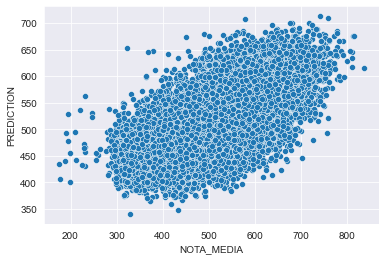

In [93]:
sns.scatterplot(data = y_rfr, x = 'NOTA_MEDIA', y = 'PREDICTION') #scatter plot of prediction as a function of the real average score

Some comments: the model was wrong, in average, by 51.3 points. The root mean squared error was 64.9 points. The graph shows that, although the model does not perfectly predict the scores (and no one said that it should!), it is good at detecting general trends. The most important result is that there is something to be learned by our model. The scores are not completely random. Although the features chosen here do not perfectly predict the scores (as already expected), they are correlated to the final score - and the fact that the model was able to learn how to predict scores to a certain extent shows this.

I will also use a neural network and compare it to the tree model. 

# Neural Network

In [139]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

I tried several different network architectures. The one below was the one that proved to work best: 5 hidden layers, with 8 nodes each. 

In [169]:
#Model building

model = Sequential()
model.add(Dense(8, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(1))

#5 hidden layers. Each layer has 8 nodes. I used the relu activation function for each layer. The output layer just outputs a number.

In [170]:
model.compile(optimizer = 'Adam', loss = 'mse') #I will use the Adam optimizer and the mean squared error as the loss

In [171]:
model.fit(x = X_train, y = y_train, epochs = 30) #training the model

Epoch 1/30
18598/18598 [==============================] - 42s 2ms/step - loss: 16490.8928
Epoch 2/30
18598/18598 [==============================] - 34s 2ms/step - loss: 4487.9622
Epoch 3/30
18598/18598 [==============================] - 32s 2ms/step - loss: 4381.8603
Epoch 4/30
18598/18598 [==============================] - 34s 2ms/step - loss: 4363.4100
Epoch 5/30
18598/18598 [==============================] - 35s 2ms/step - loss: 4331.6923
Epoch 6/30
18598/18598 [==============================] - 38s 2ms/step - loss: 4290.0546
Epoch 7/30
18598/18598 [==============================] - 34s 2ms/step - loss: 4298.4331
Epoch 8/30
18598/18598 [==============================] - 27s 1ms/step - loss: 4269.8934
Epoch 9/30
18598/18598 [==============================] - 26s 1ms/step - loss: 4248.9853
Epoch 10/30
18598/18598 [==============================] - 27s 1ms/step - loss: 4240.1972
Epoch 11/30
18598/18598 [==============================] - 27s 1ms/step - loss: 4238.2039
Epoch 12/30
18598/

In [172]:
nn_pred = model.predict(X_test) #generating predictions

In [173]:
nn_pred_df = pd.DataFrame(nn_pred, columns = ['PREDICTION'])
nn_pred_df.index = y_test.index #transforming predictions in Data Frame

In [174]:
y_nn = pd.concat([y_test, nn_pred_df], axis = 1) #concatenate test and predictions

In [175]:
print('MAE:', metrics.mean_absolute_error(y_test, nn_pred))
print('MSE:', metrics.mean_squared_error(y_test, nn_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, nn_pred))) #evaluation metrics

MAE: 51.400774224195274
MSE: 4225.06282392476
RMSE: 65.00048325916323


<AxesSubplot:xlabel='NOTA_MEDIA', ylabel='PREDICTION'>

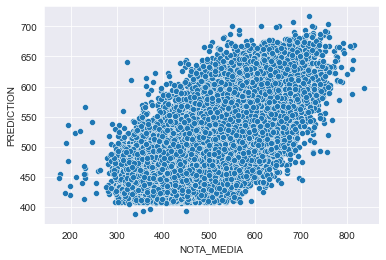

In [176]:
sns.scatterplot(data = y_nn, x = 'NOTA_MEDIA', y = 'PREDICTION') #plot result

Although the neural network (NN) model performed marginally better than the random forest (RF), we can see that the results were very similar: the mean average error was 51.4 for the NN and 51.3 for the RF. The RMSE was 65 for the NN and 64.9 for the RF. For this analysis, it seems like the tree model almost exausts what there is to be learned - and does not leave much room for improvement from the part of the neural network. 

It is interesting to notice that increasing the number of hidden layers in the NN did not lead to an increase in the accuracy of the model. A decrease in the number of hidden layers, however, led to an increase in the MSE.

# Conclusion

The EDA performed here helped us elucidate some points about how socioeconomic factors may are correlated with the ENEM score. We see that the average scores are strongly correlated with the family income (and hence, the class) of the candidates. The differences in school type (that is, if the school is private or public) also seem to have an impact on the average score. However, this seems to be less predictive of the final ENEM score, since in general higher income families send their children to private schools. In fact, when we plot a bar plot for the average scores for public and private schools for each income bracket, we can see that the public/private school divide is more predictive of the score for lower income candidates, while the difference between school types tends to decrease as the income gets higher.

The region of the country where the student lives also has an influence on the average score. The region with the highest average score is the Southeast. Only two regions (Southeast and South) have an average score greater than 500. The North is the region with the lowest score. 

I also tried to create machine learning models that attempted to predict the scores based on some socieconomic features. First, I trained a random forest, with 40 estimators (that proved to be a satisfactory number of estimators in my analysis). In average, the model got the average score wrong by 51.3 points (RMSE 64.9). There was clearly something to be learned by our model here - the model's accuracy increases with the number of estimators, and the graph shows that it captures general trends in the population score. Furthermore, I trained a neural network. I used 5 hidden layers, with 8 nodes each. The results were not much different from the random forest ones (mean absolute error 51.4 and RMSE 65). This shows that the random forest is a very good model to predict the ENEM scores. 

It should be pointed out that trying to predict the scores of an exam is an intrinsecally tricky affair. We can never have access to all variables that are important to the problem in hand - individual factors not taken into account in our analyses play a huge role. It was never my intention, in this project, to claim that any individual ENEM score can be predicted with any level of accuracy. The intention was to detect general trends and show that the some features are reasonable predictors of the scores, when a large group is taken into account. 